In [2]:
# Gaussian discriminant analysis in 2d
# Author: Duane Rich, heavily modified by Kevin Murphy
# Based on matlab code by Kevin Murphy
# https://github.com/probml/pmtk3/blob/master/demos/discrimAnalysisDboundariesDemo.m

try:
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [6]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.preprocessing import OneHotEncoder


import numpy as np
import matplotlib.pyplot as plt
import os

figdir = "figures"
figdir = "/Users/kpmurphy/github/bookv2/figures"


def savefig(fname):
    plt.savefig(os.path.join(figdir, fname))

In [44]:
def mvn2d(x, y, u, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_inv = np.linalg.inv(sigma)
    z = np.dot((xy - u), sigma_inv)
    z = np.sum(z * (xy - u), axis=1)
    z = np.exp(-0.5 * z)
    z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
    return z.reshape(xx.shape)


# Each model specifies the means and covariances.
# If the covariances are equal across classes, dboundarioes
# will be linear even if we use QDA


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


Sigma1 = np.array([[4, 1], [1, 2]])
Sigma2 = np.array([[2, 0], [0, 1]])
Sigma3 = np.eye(2)

mus = [[0, 0], [0, 4], [4, 4]]
sigmas = [Sigma1, Sigma2, Sigma3]
# model = ([[0, 0], [0, 4], [4, 4]], [Sigma1, Sigma2, Sigma3])

ngrid = 200
n_samples = 30  # 300  # number of each class samples
model_names = ("LDA", "QDA")
np.random.seed(0)


def make_data(mu, sigma):
    # generate random points
    x = []  # store sample points
    labels = []  # store class labels
    nclasses = len(mu)  # means
    for i in range(nclasses):
        x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples))
        labels.append([i] * n_samples)
    return x, labels


def make_grid(x):
    points = np.vstack(x)
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range


def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], lw=3, colors="k")


def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        N = point.shape[0]
        nplot = min(N, 30)
        plt.plot(point[:nplot, 0], point[:nplot, 1], c[i] + m[i])


def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])


def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)  # make 2d
    enc = OneHotEncoder(sparse=False)
    Y = enc.fit_transform(yy)
    return Y

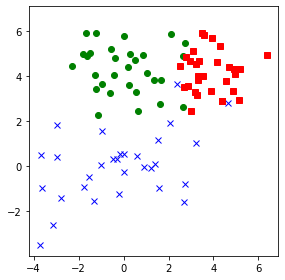

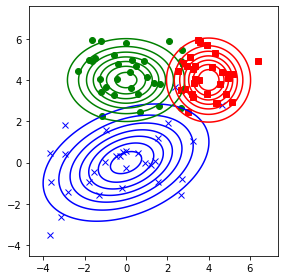

In [45]:
x, labels = make_data(mus, sigmas)
xx, yy, x_range, y_range = make_grid(x)
X = np.vstack(x)
Y = np.hstack(labels)

plt.figure()
plot_points(x)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_data.pdf")
plt.show()

plt.figure()
plot_points(x)
plot_contours(xx, yy, x_range, y_range, mus, sigmas)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_contours.pdf")
plt.show()

In [46]:
def estimate_mvns(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        Sigma_c = np.cov(Xc, rowvar=False)
        mus.append(mu_c)
        sigmas.append(Sigma_c)
    return mus, sigmas


mus_est, sigmas_est = estimate_mvns(X, Y)

In [47]:
def estimate_mvn_tied(X, Y):
    classes = np.unique(Y)
    nclasses = len(classes)
    Sigma = np.cov(X, rowvar=False)
    sigmas = [Sigma] * nclasses
    mus = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        mus.append(mu_c)
    return mus, sigmas


mus_tied, sigmas_tied = estimate_mvn_tied(X, Y)

In [48]:
for c in range(3):
    print("class ", c, " mean")
    print(mus[c])
    print(mus_est[c])
    print(mus_tied[c])
    print("class ", c, " cov")
    print(sigmas[c])
    print(sigmas_est[c])
    print(sigmas_tied[c])

class  0  mean
[0, 0]
[-0.19071545  0.02087736]
[-0.19071545  0.02087736]
class  0  cov
[[4 1]
 [1 2]]
[[5.1804617  1.60254369]
 [1.60254369 2.27798452]]
[[6.10718958 2.40985185]
 [2.40985185 5.3902066 ]]
class  1  mean
[0, 4]
[0.07952598 4.32087903]
[0.07952598 4.32087903]
class  1  cov
[[2 0]
 [0 1]]
[[ 2.07126704 -0.18360974]
 [-0.18360974  1.1113116 ]]
[[6.10718958 2.40985185]
 [2.40985185 5.3902066 ]]
class  2  mean
[4, 4]
[3.86351869 4.16570271]
[3.86351869 4.16570271]
class  2  cov
[[1. 0.]
 [0. 1.]]
[[ 0.86052694 -0.01592137]
 [-0.01592137  0.84489956]]
[[6.10718958 2.40985185]
 [2.40985185 5.3902066 ]]


In [37]:
def fit_and_plot(clf, name, mus, sigmas):
    clf.fit(X, Y)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(ngrid, ngrid)
    z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Yhat = make_one_hot(yhat)

    plt.figure()
    # plot_dboundaries(xx, yy, z, z_p)
    plot_dboundaries(xx, yy, z, Yhat)
    plot_points(x)
    plot_contours(xx, yy, x_range, y_range, mus, sigmas)
    plt.title(name)
    plt.axis("square")
    plt.tight_layout()
    savefig("gda_2d_{}.pdf".format(name))
    plt.show()

<ipython-input-44-7d6d2b5e0de0>:60: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], lw=3, colors="k")


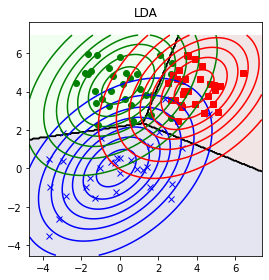

In [49]:
fit_and_plot(LDA(), "LDA", mus_tied, sigmas_tied)

<ipython-input-44-7d6d2b5e0de0>:60: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], lw=3, colors="k")


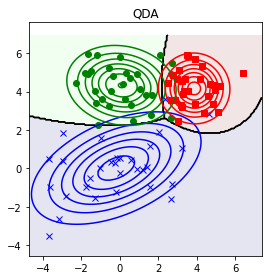

In [50]:
fit_and_plot(QDA(), "QDA", mus_est, sigmas_est)